# Classical ML

> singularity exec --overlay /scratch/lw3266/my_env/overlay-15GB-500K.ext3:rw /scratch/work/public/singularity/cuda12.3.2-cudnn9.0.0-ubuntu-22.04.4.sif /bin/bash

> source /ext3/env.sh

Pip install any additional modules needed


### Setting up
Import the modules we will need.

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score

In [4]:
df = pd.read_csv("qml_training-validation-data.csv", index_col = 0)
df.head(6)

,el_neg,B/GPa,Volume/A^3,SFE/mJm^-3
Element,,,,
Be,1.57,130.0,8.09,23.48
Sc,1.36,57.0,25.00,16.16
Ti,1.54,110.0,17.60,24.44
Co,1.88,180.0,11.00,37.64
Zn,1.65,70.0,15.20,20.98
Y,1.22,41.0,33.00,8.52


### Linear Model Training
We first divide the dataset into test and train, with a ratio of 80 to 20.

Then the linear model will be trained using the train data.

In [5]:
y = df['SFE/mJm^-3'].values
X = df[['el_neg', 'B/GPa', 'Volume/A^3']].values
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
elements = df.index.values
elementtrain = elements[:int(0.8*len(elements))]
elementtest = elements[int(0.8*len(elements)):]

regr = linear_model.LinearRegression()
regr.fit(Xtrain, ytrain)

LinearRegression()


The trained model will predict the SFE using orginal independent variables, and the output is named `ytrain_pred`. The graph is shown, and the RSS value calculated to determine whether the model is is effective.

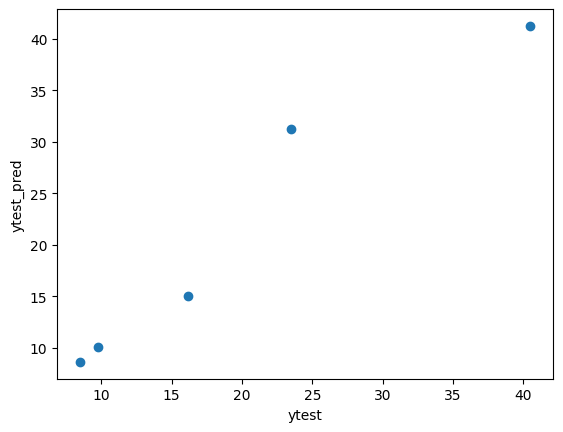

In [6]:
ytest_pred = regr.predict(Xtest)
#plt.plot(elementtrain, ytest_pred, 'o')
#plt.plot(elementtrain, ytest, 'o')
plt.scatter(ytest,ytest_pred)
plt.xlabel("ytest")
plt.ylabel("ytest_pred")
#plt.legend(["Predicted", "Actual"], bbox_to_anchor=(1, 0.9), loc='upper left')
plt.show()

In [7]:
RSS_train = np.mean((ytest_pred-ytest)**2)/(np.std(ytest)**2)
RSS_train
# RSS_train = np.sum((ytrain_pred-ytrain)**2)/np.sum((ytrain-np.mean(ytrain))**2)
r2_score(ytest_pred,ytest)

0.925101208358343

### Linear Model Testing
The testing procedure follows the training procedure, except we are using `Xtest` and `ytest`. These data sets remain untouched by the model, allowing us to measure the actual performance.

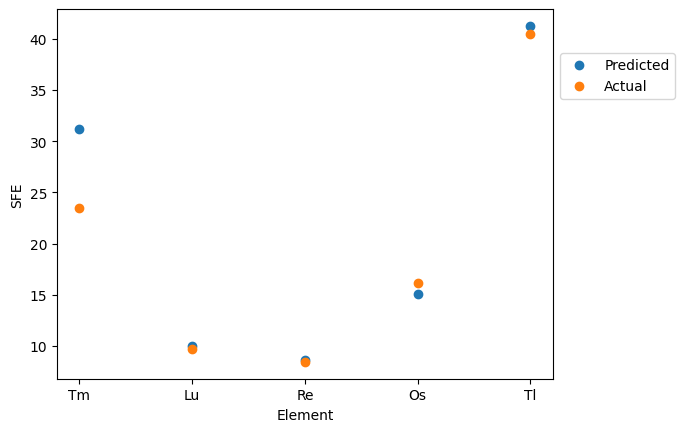

In [8]:
ytest_pred = regr.predict(Xtest)
plt.plot(elementtest, ytest_pred, 'o')
plt.plot(elementtest, ytest, 'o')

plt.xlabel("Element")
plt.ylabel("SFE")
plt.legend(["Predicted", "Actual"], bbox_to_anchor=(1, 0.9), loc='upper left')
plt.show()

### Results

Measure the normalized RSS on the test data.

In [9]:
RSS_test = np.sum((ytest_pred-ytest)**2)/np.sum((ytest-np.mean(ytest))**2)
RSS_test

np.float64(0.0900721746586783)

# Quantum Model Testing
Source: [Qiskit Machine Learning 0.7.2](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html#Regression)

## Quantum Support Vector Regressor (QSVR)
I first tried QSVR, as it is easier to set up.

### Setup

In [10]:
###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler #StandardScaler is sensitive to outlier

from qiskit_aer import Aer
from qiskit.circuit.library import PauliFeatureMap, RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms import VQR
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVR,QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [11]:

# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# X_train_scaler = StandardScaler()
# y_train_scaler = StandardScaler()
# X_test_scaler = StandardScaler()
# y_test_scaler = StandardScaler()

def prepare_dataset(y_scaler,X,y):
    X_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=test_ratio, shuffle=True)
    element_test = X_test[:,0]
    X=X[:,1:]
    max_arr=np.max(X,axis=0)
    #print("max_arr: ",max_arr,X/max_arr)
    X=X/max_arr
    #print("renormalized X: ",X)
    sample_train=X_train[:,1:]/max_arr
    sample_test=X_test[:,1:]/max_arr
    # Normalise
#     std_scale = StandardScaler().fit(X)
#     sample_train = std_scale.transform(sample_train)
#     sample_test = std_scale.transform(sample_test)

    #print(sample_train[0])
    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(sample_train)
    X_test = minmax_scale.transform(sample_test)
    #print(X_train) #[0])

#     y_test_copy = y_test
    
#     X_joined = np.concatenate((X_train[:,1:], X_test[:,1:]))
#     X_joined = X_scaler.fit_transform(X_joined.reshape(-1,3))
    
#     X_train = X_joined[:int(len(X_joined)*0.9)]
#     X_test = X_joined[int(len(X_joined)*0.9):]
    
    return X_train, y_train, X_test, y_test, element_test

In [12]:
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2)  # Adjust feature_dimension as needed
# kernel = FidelityQuantumKernel(feature_map=feature_map)


# def reconfig_feature_map(reps):
#     feature_map = ZZFeatureMap(feature_dimension=3, reps=reps,entanglement='circular', insert_barriers=True)
#     #kernel = FidelityQuantumKernel(feature_map=feature_map)
#     kernel = FidelityQuantumKernel(feature_map=feature_map)

In [13]:
# Create a quantum kernel
#qsvr = QSVR(C=20.0, epsilon=0.2, quantum_kernel=kernel)
def reconfig_quantum_kernel(C,reps):
    feature_map = ZZFeatureMap(feature_dimension=3, reps=reps,entanglement='circular', insert_barriers=True)
    #kernel = FidelityQuantumKernel(feature_map=feature_map)
    kernel = FidelityQuantumKernel(feature_map=feature_map)
    #qsvr = QSVR(C=20.0, epsilon=0.2, quantum_kernel=kernel)
    qsvr = QSVR(C=1.0, epsilon=0.1, quantum_kernel=kernel)
    return qsvr

In [14]:
def train(qsvr,X_train, y_train):
    qsvr.fit(X_train, y_train)
    y_hat = qsvr.predict(X_test)
    return y_hat

In [15]:
def graph(y_scaler, y_hat, y_test, message):
    y_hat = y_scaler.inverse_transform(y_hat.reshape(-1,1))
    y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
    plt.plot(elementtest, y_hat, 'o')
    plt.plot(elementtest, y_test, 'o')
    
    plt.xlabel("Element")
    plt.ylabel("SFE")
    plt.legend(["Predicted", "Actual"], bbox_to_anchor=(1, 0.9), loc='upper left')
    plt.savefig(message,dpi=300)
    # plt.show()
    plt.clf()
    return y_test, y_hat

In [16]:
def accuracy(y_test, y_hat):
    return r2_score(y_test, y_hat)

j:  1
R2 score:  0.7120211514260149


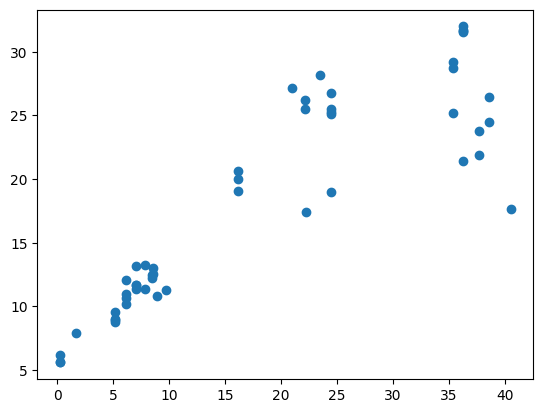

In [17]:
df = pd.read_csv("qml_training-validation-data.csv")
X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
y = df['SFE/mJm^-3'].values

y_scaler = MinMaxScaler()

test_ratio = 0.2 #0.1

reps = 1
reps_end = 2 #5 #11
C = 1
C_end = 2 #10 #21
iter = 10 #20 #30

import warnings
warnings.filterwarnings('ignore')

template = "QSVR/zz/QVSR_zz_"
df = pd.DataFrame(columns=['reps', 'C', 'i', 'r^2'])
y_test_all, y_hat_all=[],[]
for j in range(C, C_end): # C
    print("j: ", j)
    for reps_z in range(reps, reps_end):# reps
        for i in range(iter):
            message = ''
            message += template
            message += f"{reps_z}_{j}_i{i}_prediction.png"
            X_train, y_train, X_test, y_test, elementtest = prepare_dataset(y_scaler,X,y)
            #reconfig_feature_map(z)
            qsvr=reconfig_quantum_kernel(j,reps_z)
            y_hat = train(qsvr,X_train, y_train)
            y_test, y_hat = graph(y_scaler,y_hat, y_test, message)
            y_test_all.append(y_test), y_hat_all.append(y_hat)
            new_row = {'reps': reps_z, 'C': j, 'i': i, 'r^2': accuracy(y_test, y_hat)}
            df.loc[len(df)] = new_row
y_test_all=np.concatenate(y_test_all)
y_hat_all=np.concatenate(y_hat_all)
print("R2 score: ",accuracy(y_test_all, y_hat_all))
plt.scatter(y_test_all,y_hat_all)
plt.savefig("QSVR/zz/all.png",dpi=300)
df.to_csv('QSVR/zz/result/data.csv', index=False) 

# Classification task

In [18]:
#classification task
def reconfig_quantum_kernel_qsvc(C,reps):
    feature_map = ZZFeatureMap(feature_dimension=3, reps=reps,entanglement='circular', insert_barriers=True)
    kernel = FidelityQuantumKernel(feature_map=feature_map)
    qsvc = QSVC(quantum_kernel=kernel)
    return qsvc
def accuracy_qsvc(y_test, y_hat):
    agree=0
    for i in range(len(y_test)):
        if round(y_test[i]-y_hat[i],1)==0:
            agree+=1
    return agree/len(y_test)
def prepare_dataset(X,y):
    X_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=test_ratio, shuffle=True)
    element_test = X_test[:,0]
    X=X[:,1:]
    max_arr=np.max(X,axis=0)
    #print("max_arr: ",max_arr,X/max_arr)
    X=X/max_arr
    #print("renormalized X: ",X)
    sample_train=X_train[:,1:]/max_arr
    sample_test=X_test[:,1:]/max_arr
    # Normalise
#     std_scale = StandardScaler().fit(X)
#     sample_train = std_scale.transform(sample_train)
#     sample_test = std_scale.transform(sample_test)

    #print(sample_train[0])
    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(sample_train)
    X_test = minmax_scale.transform(sample_test)
    
    return X_train, y_train, X_test, y_test, element_test

In [19]:
#preprocessing data
df = pd.read_csv("qml_training-validation-data.csv")
X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
y = df['SFE/mJm^-3'].values
for i in range(0,len(y)): 
    if y[i]>19: y[i]=0
    else: y[i]=1
print(y)

[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


In [20]:

#y_scaler = MinMaxScaler()

test_ratio = 0.2 #0.1

reps = 1
reps_end = 2 #5 #11
C = 1
C_end = 2 #10 #21
iter = 10 #20 #30

import warnings
warnings.filterwarnings('ignore')

template = "QSVC/zz/QVSC_zz_"
df = pd.DataFrame(columns=['reps', 'C', 'i', 'r^2'])
y_test_all, y_hat_all=[],[]
for j in range(C, C_end): # C
    for reps_z in range(reps, reps_end):# reps
        for i in range(iter):
            message = ''
            message += template
            message += f"{reps_z}_{j}_i{i}_prediction.png"
            X_train, y_train, X_test, y_test, elementtest = prepare_dataset(X,y)
            #reconfig_feature_map(z)
            qsvc=reconfig_quantum_kernel_qsvc(j,reps_z)
            y_hat = train(qsvc,X_train, y_train)
            #y_test, y_hat = graph(y_scaler,y_hat, y_test, message)
            y_test_all.append(y_test), y_hat_all.append(y_hat)
            new_row = {'reps': reps_z, 'C': j, 'i': i, 'r^2': accuracy(y_test, y_hat)}
            df.loc[len(df)] = new_row
y_test_all=np.concatenate(y_test_all)
y_test_all=np.transpose(y_test_all)[0]
y_hat_all=np.concatenate(y_hat_all)
print("y_test_all: ",y_test_all)
print("y_hat_all: ",y_hat_all)
print("accuracy: ",accuracy_qsvc(y_test_all, y_hat_all))
#plt.scatter(y_test_all,y_hat_all)
plt.savefig("QSVR/zz/all.png",dpi=300)
df.to_csv('QSVR/zz/result/data.csv', index=False) 

y_test_all:  [0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1.]
y_hat_all:  [0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1.]
accuracy:  0.92


<Figure size 640x480 with 0 Axes>

## EstimatorQNN (NOT TESTED AND NEEDS A FIX)

The second attempt uses EstimatorQNN to perform a regression. EstimatorQNN evaluates quantum mechanical observables (some quantum state that can be obtained by a sequence of operatorion. Source: Wikipedia). We will also construct a QNNCircuit, which involves input parameters and an ansatz.

Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

### Setup

In [21]:
from sklearn.preprocessing import MinMaxScaler

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

In [22]:
#functions

def prepare_dataset(y_scaler,X,y):
    X_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=test_ratio, shuffle=True)
    element_test = X_test[:,0]
    X=X[:,1:]
    max_arr=np.max(X,axis=0)
    #print("max_arr: ",max_arr,X/max_arr)
    X=X/max_arr
    #print("renormalized X: ",X)
    sample_train=X_train[:,1:]/max_arr
    sample_test=X_test[:,1:]/max_arr
    # Normalise
#     std_scale = StandardScaler().fit(X)
#     sample_train = std_scale.transform(sample_train)
#     sample_test = std_scale.transform(sample_test)

    #print(sample_train[0])
    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(sample_train)
    X_test = minmax_scale.transform(sample_test)
    #print(X_train) #[0])
    
    return X_train, y_train, X_test, y_test, element_test

### Prepare Dataset

In [23]:
df = pd.read_csv("qml_training-validation-data.csv")
X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
y = df['SFE/mJm^-3'].values

y_scaler = MinMaxScaler((-1, 1))

test_ratio = 0.2 #0.1

X_train, y_train, X_test, y_test, element_test = prepare_dataset(y_scaler,X,y)

# elementtest = X_test[:,0]
# X = MinMaxScaler().fit_transform(X[:,1:])
# # y = MinMaxScaler().fit_transform(y.reshape(-1,1))
# # print(X)

# test_ratio = 0.1
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True)
# elementtest = X_test[:,0]

### Regression with EstimatorQNN

In [24]:
# Construct the feature map

from qiskit.circuit.library import ZZFeatureMap

num_qubits = 3

# QNN of Leyang; this model has a low score of 0.0369
def regression_estimator_qnn1(num_qubits):
 # Construct the ansatz
  param_y = Parameter("y")
  ansatz = QuantumCircuit(num_qubits, name="vf")
  for i in range(num_qubits):
    ansatz.ry(param_y, i)

 # Construct the circuit
  qc = QNNCircuit(feature_map=ZZFeatureMap(num_qubits,reps=1), ansatz=ansatz)

 # construct QNN
  regression_estimator_qnn = EstimatorQNN(circuit=qc)

  return regression_estimator_qnn

#QNN1; this QNN model gives a score of 0.801
def regression_estimator_qnn2(num_qubits):
  qnn_qc = QNNCircuit(num_qubits)

  regression_estimator_qnn = EstimatorQNN(
    circuit=qnn_qc
  )
  return regression_estimator_qnn
    
#QNN2; this model gives a score of 0.788
def regression_estimator_qnn3(num_qubits):
  feature_map = ZZFeatureMap(feature_dimension=num_qubits)
  ansatz = RealAmplitudes(num_qubits=num_qubits)

  qc = QuantumCircuit(num_qubits)
  qc.compose(feature_map, inplace=True)
  qc.compose(ansatz, inplace=True)

  regression_estimator_qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
  )
  return regression_estimator_qnn

regression_estimator_qnn=regression_estimator_qnn3(num_qubits) #1,2,3 has different score

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [25]:
# qc.draw("mpl", style="clifford")

### Regressor Construction

In [26]:
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn, 
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=10), #5
    callback=callback_graph,
)

### Training

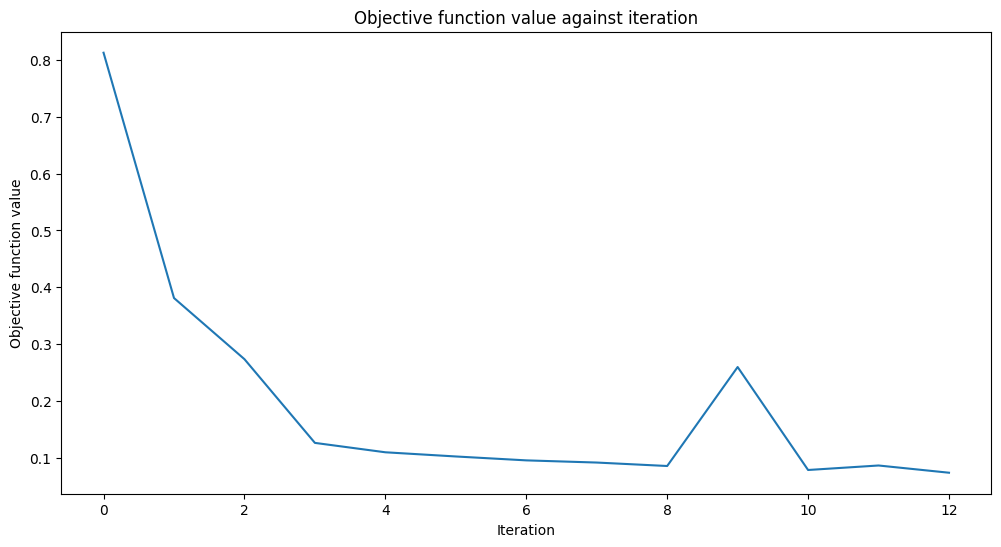

0.7626153834511092

In [27]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X_train, y_train)

[[31.04548334]
 [14.38282469]
 [25.94668282]
 [31.67712656]
 [12.14263056]]


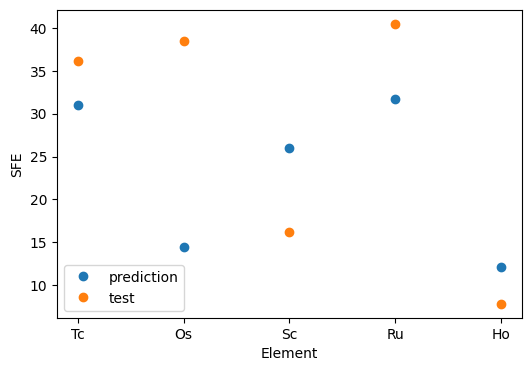

In [28]:
y_hat = regressor.predict(X_test)
y_hat = y_scaler.inverse_transform(y_hat.reshape(-1,1))
print(y_hat)
y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(element_test, y_hat, 'o', label="prediction")
plt.plot(element_test, y_test, 'o', label="test")

plt.xlabel("Element")
plt.ylabel("SFE")
#plt.legend(["Predicted", "Actual"], bbox_to_anchor=(1, 0.9), loc='upper left')
plt.legend()
plt.show()

## Variational Quantum Regressor (VQR)

### Setup

In [29]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import time
import csv
from pathlib import Path

from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
#from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.algorithms.regressors import VQR

#import seaborn as sns

### Prepare Dataset

In [30]:
#functions

def prepare_dataset(y_scaler,test_ratio,X,y):
    X_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=test_ratio, shuffle=True)
    element_test = X_test[:,0]
    X=X[:,1:]
    max_arr=np.max(X,axis=0)
    #print("max_arr: ",max_arr,X/max_arr)
    X=X/max_arr
    #print("renormalized X: ",X)
    sample_train=X_train[:,1:]/max_arr
    sample_test=X_test[:,1:]/max_arr
    # Normalise
#     std_scale = StandardScaler().fit(X)
#     sample_train = std_scale.transform(sample_train)
#     sample_test = std_scale.transform(sample_test)

    #print(sample_train[0])
    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(sample_train)
    X_test = minmax_scale.transform(sample_test)
    #print(X_train) #[0])
    
    return X_train, y_train, X_test, y_test, element_test




In [31]:
# df = pd.read_csv("qml_training-validation-data.csv")
# X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
# y = df['SFE/mJm^-3'].values

# test_ratio = 0.1
# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# X_train_scaler = StandardScaler()
# y_train_scaler = StandardScaler()
# X_test_scaler = StandardScaler()
# y_test_scaler = StandardScaler()

# def prepare_dataset(X, y, X_scaler, y_scaler, test_ratio):
#     y = y_scaler.fit_transform(y.reshape(-1,1))
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True)
#     y_test_copy = y_test
    
#     X_joined = np.concatenate((X_train[:,1:], X_test[:,1:]))
#     X_joined = X_scaler.fit_transform(X_joined.reshape(-1,3))

#     element_test = X_test[:,0]
    
#     X_train = X_joined[:int(len(X_joined)*0.9)]
#     X_test = X_joined[int(len(X_joined)*0.9):]
    
#     # X_train = X_train_scaler.fit_transform(X_train[:,1:])
#     # y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
#     # y_train = y_train.reshape(-1,1)
    
#     # X_test = X_test_scaler.fit_transform(X_test[:,1:])
#     # y_test = y_scaler.fit_transform(y_test.reshape(-1,1))
#     # y_test = y_test.reshape(-1,1)

#     return X_train, y_train, X_test, y_test, element_test

### Feature Map

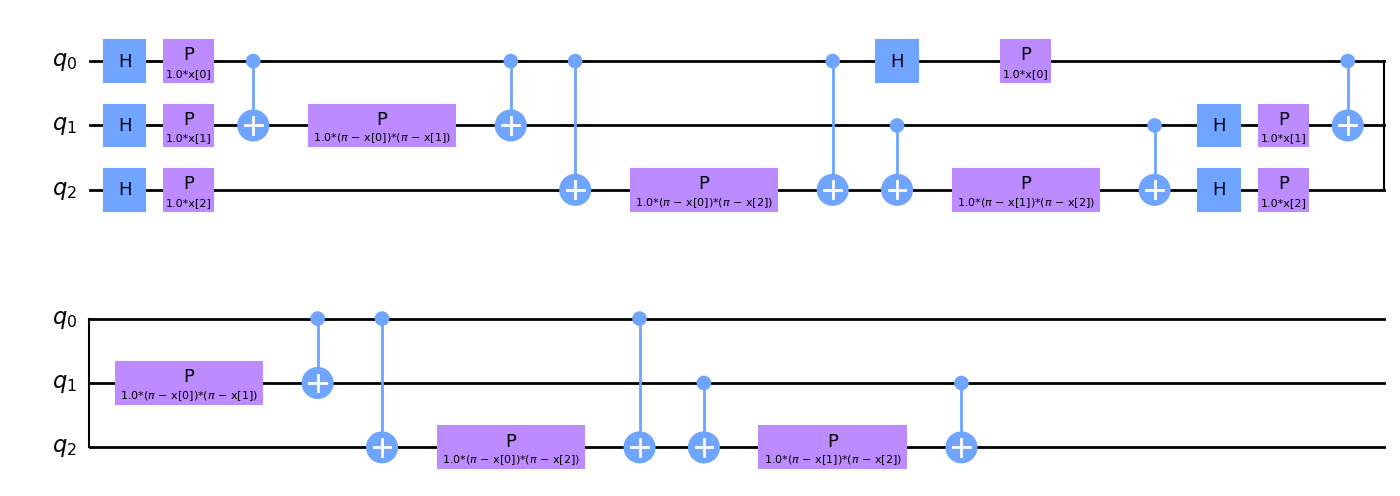

In [32]:
feature_map = PauliFeatureMap(feature_dimension=3, reps=2, entanglement='full', alpha=1.0)
def reconfig_featureMap(alpha):
    feature_map = PauliFeatureMap(feature_dimension=3, reps=2, entanglement='full', alpha=alpha)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

### Ansatz

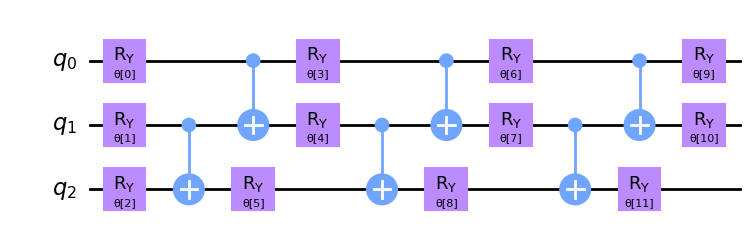

In [33]:
ansatz = RealAmplitudes(num_qubits=3, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

### Optimizer

In [34]:
optimizer = COBYLA(maxiter=100)

### Objective Function and Callback Graphing

In [35]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Training

In [36]:
def train(X_train, y_train, message):
    vqr = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
    )
    
    # clear objective value history
    objective_func_vals = []
    
    start = time.time()
    vqr.fit(X_train, y_train)
    elapsed = time.time() - start

    # plt.savefig(Path(message+"train.png"),dpi=300) # not gonna work
    
    print(f"Training time: {round(elapsed)} seconds")
    return vqr

In [37]:
def print_train_result(vqr, X_train, y_train):
    train_score = vqr.score(X_train, y_train)
    return train_score

In [38]:
def show_prediction_graph(y_scaler, vqr, element_test, y_test, message):
    # y_hat = vqr.predict(X_test_scaler.inverse_transform(X_test))
    y_hat = vqr.predict(X_test)
    y_test = y_scaler.inverse_transform(y_test)
    y_hat = y_scaler.inverse_transform(y_hat)
    plt.plot(element_test, y_scaler.inverse_transform(y_hat), 'o')
    plt.plot(element_test, y_scaler.inverse_transform(y_test), 'o')
    
    plt.xlabel("Element")
    plt.ylabel("SFE")
    plt.legend(["Predicted", "Actual"], bbox_to_anchor=(1, 0.9), loc='upper left')

    plt.savefig(Path(message+"prediction.png"),dpi=300)
    plt.show()

    return y_test, y_hat

In [39]:
def accuracy(y_test, y_hat):
    return r2_score(y_test, y_hat)

### Recursive Tests

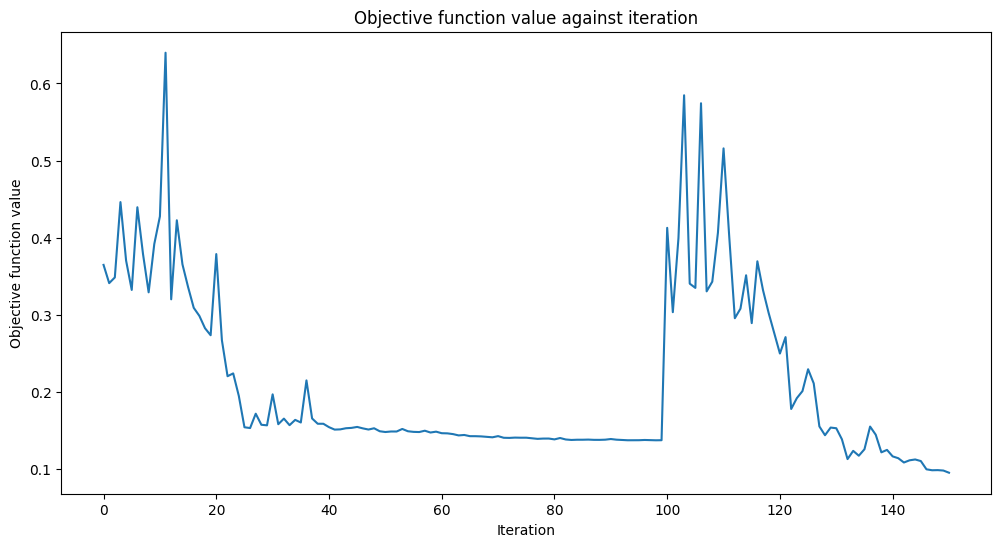

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [40]:
df = pd.read_csv("qml_training-validation-data.csv")
X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
y = df['SFE/mJm^-3'].values

y_scaler = MinMaxScaler((-1, 1))

test_ratio = 0.2 #0.1

#X_train, y_train, X_test, y_test, element_test = prepare_dataset(y_scaler,X,y)

y_test_all, y_hat_all=[],[]

iter = 10 # 30

# edit this
template = "VQR/pauli/VQR_pauli_j_ii_"
# ! mkdir VQR/pauli
start = 1
end = 2
step = 0.1
with open('VQR/pauli/accuracy.csv', mode='w', newline='') as file: 
    writer = csv.writer(file)
    
    for j in range(int((end-start)/step)+1):
        pairs = []
        for i in range(iter):
            reconfig_featureMap(start)
            message = template[:20] + str(round(start,1)) + template[21:23] + str(i) + template[24:] # modify the output figure name
            X_train, y_train, X_test, y_test, element_test = prepare_dataset(y_scaler,test_ratio,X,y) #prepare_dataset(X, y, X_scaler, y_scaler, test_ratio)
            vqr = train(X_train, y_train, message)
            y_test, y_hat = show_prediction_graph(y_scaler, vqr, element_test, y_test, message)
            y_test_all.append(y_test), y_hat_all.append(y_hat)
            pair = (y_test, y_hat)
            pairs.append(pair)
            
        r2_values = [r2_score(pair[0], pair[1]) for pair in pairs]

        writer.writerow(r2_values)

        plt.figure(figsize=(8,6))
        #sns.boxplot(data=r2_values)
        plt.title("Whisker Plot for R^2 Values")
        plt.ylabel("R^2")
        plt.savefig(f"VQR/pauli/VQR_pauli_{round(start,1)}_r2.png",dpi=300)
            
        start += step

y_test_all=np.concatenate(y_test_all)
y_hat_all=np.concatenate(y_hat_all)
print("R2 score: ",accuracy(y_test_all, y_hat_all))


In [ ]:
# different feature map
# scaling
# Entanglement